# Fitting a 2D Gaussian Tensor Train model to toy data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import scipy
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfm = tf.math

# setup path for repo imports
import sys, os
sys.path.append('../')

# 
%load_ext autoreload
%autoreload 2

## Import Toy data

In [2]:
from data import to_tf_dataset
from data import gen_checkerboard as gen_data

# Number of datapoints to generate
N = 10000
batch_size = 64

# Generate toy data
data = gen_data(batch_size=N)

# Reserve some data for testing
x_val = data[-1000:]
x_train = data[:-1000]

# Prepare the datasets
ds_train = to_tf_dataset(x_train, batch_size=batch_size)
ds_val  = to_tf_dataset(x_val, batch_size=batch_size)

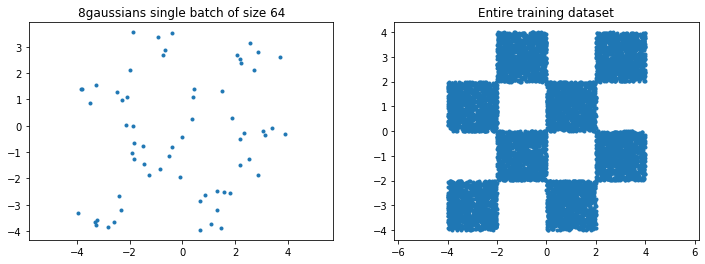

In [3]:
# Plot a single batch of the train dataset
single_batch = list(ds_train)[0]
f, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(single_batch[:, 0], single_batch[:, 1], '.')
ax[0].axis('equal')
ax[0].set_title(f'8gaussians single batch of size {batch_size}')
ax[1].plot(x_train[:, 0], x_train[:, 1], '.')
ax[1].axis('equal')
ax[1].set_title(f'Entire training dataset')
plt.show()

## Fit model to data

In [4]:
# create model
from models import TensorTrainGaussian2D as ttmodel
K = 5
model = ttmodel(K)

# Instantiate an optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

In [5]:
for X in ds_train:
    break

# likelihoods = tf.zeros((X.shape[0]), dtype=tf.dtypes.float32)
Wk0 = tf.nn.softmax(model.Wk0)
Wk1k0 = tf.nn.softmax(model.Wk1k0, axis=0)
Wk2k1 = tf.nn.softmax(model.Wk2k1, axis=0)

d1 = []
d2 = []
# [d1.append(X[:, 0]) for s in range(model.K**2)]
# [d2.append(X[:, 1]) for s in range(model.K**2)]
d1.append(X[0, 0])
d2.append(X[0, 1])

d1 = tf.dtypes.cast(d1, tf.float32)
d2 = tf.dtypes.cast(d2, tf.float32)

# print(d1[0].dtype)
# print(Wk1k0.dtype)

A = Wk1k0
B = np.reshape(model.joint.log_prob_parts(d1), (model.K, model.K, -1))
C = Wk2k1
D = np.reshape(model.joint.log_prob_parts(d2), (model.K, model.K, -1))

res1 = tf.multiply(A[:, :], B)
res2 = tf.multiply(C[:, :], D)
res = tf.tensordot(res1, tf.transpose(res2), axes=2)
z = Wk0

likelihoods = tf.reduce_sum(tf.tensordot(z, res, axes=1))


# likelihoods = np.sum(z @ res, axis=1)
# likelihoods = tf.convert_to_tensor(likelihoods, dtype=tf.float32)

# print( tfm.log(likelihoods + np.finfo(np.float32).eps) )

# print(tfm.log(likelihoods + np.finfo(np.float32).eps))

print(z.shape, z.dtype)
print(res.shape, z.dtype)
print(likelihoods.shape)
print(likelihoods)

(5,) <dtype: 'float32'>
(5, 5) <dtype: 'float32'>
()


In [ ]:
# dist = []
# cat = np.ones(K)/K
# for i in range(0, K):
#     for j in range(0, K):
#         dist.append(tfd.Normal(1, 1))

# mix = tfd.JointDistributionSequential(dist)
# print(mix)
# model.dist.shape
# print(tf.__version__)

# tfd.JointDistributionSequential
for x in ds_train:
    # print("x =", x)
    print("m(x) =", model(x))
    break
    # print(x)
# x = np.array(single_batch[0, 0])
# print(x)
# A = model.Wk1k0
# B = np.reshape(model.joint.log_prob_parts(x), (K, K))

# tf.multiply(A, B)

# model(x)

# 
# model.joint.log_prob_parts(x)

# np.reshape(mix.log_prob_parts([0]), (K, K))

In [ ]:
# Fit the model
EPOCHS = 20
# tf.config.run_functions_eagerly(True) # try to add this if you get an error
for epoch in range(EPOCHS):
    
    # Iterate over the batches of the dataset
    for i, x in enumerate(ds_train):
        loss_value = model.train_step(x, optimizer)

    print(
        "Training loss of last batch of epoch %d: %.4f"
        % (epoch + 1, float(loss_value))
    )

    # INSERT SOME KIND OF VALIDATION LOOP

In [ ]:
# Set number of points and limits
n_points = 1000
lim = 4

from utils import plot_contours, plot_density
f, ax = plt.subplots(1, 2, figsize=(12,4))
plot_contours(ax[0], x_val, model, lim, n_points)
plot_density(ax[1], model, lim, n_points)